- Play with decision tree hyperparams
- Play with impurity
- Adding more trees to RF with CV
- Decision tree classification
- max features in boosting


# Set up

In [1]:
import pandas as pd
import patsy
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math
import random

# Getting data

In [2]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [3]:
element_gameweek_df = pd.read_csv(file_name)

In [4]:
current_event = 38

In [5]:
last_train_event = 30

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [7]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [8]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

In [9]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [10]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

In [11]:
formula = \
'total_points ~ C(team) + C(opposition_team) + C(element_type) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
 ]])

In [12]:
print(formula)

total_points ~ C(team) + C(opposition_team) + C(element_type) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_missed_element +

In [13]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [14]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Decision trees

**What's going on?** 

Decision trees recursively partition the feature space into M regions using a series of binary splits - this is known as the CART methodology (Classification and Regression Trees).  

In each resulting region of the feature space we predict the target variable using the corresponding sample mean in that region.

$$ f(x) = \sum_{m=0}^M c_m \, I(x \in R_m) $$  

$$ \hat c_m = \bar y_m = {\sum_{i=1}^N y_i \, I(x_i \in R_m) \over \sum_{i=1}^N I(x_i \in R_m)} $$

**How we split**

For a given loss function, the feature set is split on a particular feature at a particular split point, so to minimise the loss. For regression trees, we use the squared-error loss.

$$ R_1 = \{x \, | \, x_j <= s\}, \; R_2 = \{x \, | \, x_j > s\} $$

$$ \min_{j, s} \sum_{i=1}^N (y_i - \bar y_1)^2 I(x_i \in R_1) + (y_i - \bar y_2)^2 I(x_i \in R_2)  $$

Regions are recursively split until some stopping criteria is satisfied, e.g. the size of the tree. As such, a tree of binary decision junctions (nodes) is grown where each terminal node (leaf) corresponds to a certain region of the feature set.

## Growing a tree

We're going to grow a tree to predict the number of points scored by fantasy players based on a bunch of features, shown below

In [324]:
X.design_info.column_names

['Intercept',
 'C(team)[T.2]',
 'C(team)[T.3]',
 'C(team)[T.4]',
 'C(team)[T.5]',
 'C(team)[T.6]',
 'C(team)[T.7]',
 'C(team)[T.8]',
 'C(team)[T.9]',
 'C(team)[T.10]',
 'C(team)[T.11]',
 'C(team)[T.12]',
 'C(team)[T.13]',
 'C(team)[T.14]',
 'C(team)[T.15]',
 'C(team)[T.16]',
 'C(team)[T.17]',
 'C(team)[T.18]',
 'C(team)[T.19]',
 'C(team)[T.20]',
 'C(opposition_team)[T.2]',
 'C(opposition_team)[T.3]',
 'C(opposition_team)[T.4]',
 'C(opposition_team)[T.5]',
 'C(opposition_team)[T.6]',
 'C(opposition_team)[T.7]',
 'C(opposition_team)[T.8]',
 'C(opposition_team)[T.9]',
 'C(opposition_team)[T.10]',
 'C(opposition_team)[T.11]',
 'C(opposition_team)[T.12]',
 'C(opposition_team)[T.13]',
 'C(opposition_team)[T.14]',
 'C(opposition_team)[T.15]',
 'C(opposition_team)[T.16]',
 'C(opposition_team)[T.17]',
 'C(opposition_team)[T.18]',
 'C(opposition_team)[T.19]',
 'C(opposition_team)[T.20]',
 'C(element_type)[T.2]',
 'C(element_type)[T.3]',
 'C(element_type)[T.4]',
 'was_home',
 'is_sunday',
 'is_we

For simplicity, let's restrict our feature set to just a few features

In [310]:
example_cols = [
    'is_early',
    'rolling_avg_fouls_element',
    'rolling_avg_saves_element'
]

example_features_index = \
[True if i in example_cols else False for i in X.design_info.column_names]

X_example = X[:,example_features_index]


In [311]:
X_example

array([[0.        , 0.        , 6.        ],
       [0.        , 0.        , 7.        ],
       [1.        , 0.        , 6.        ],
       ...,
       [0.        , 0.71428571, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 5.        ]])

We're also going to restrict our tree to a depth of 3

In [312]:
model_example = DecisionTreeRegressor(max_depth=3)

model_example.fit(X_example, y.ravel())

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

We can visualise the resulting decision tree

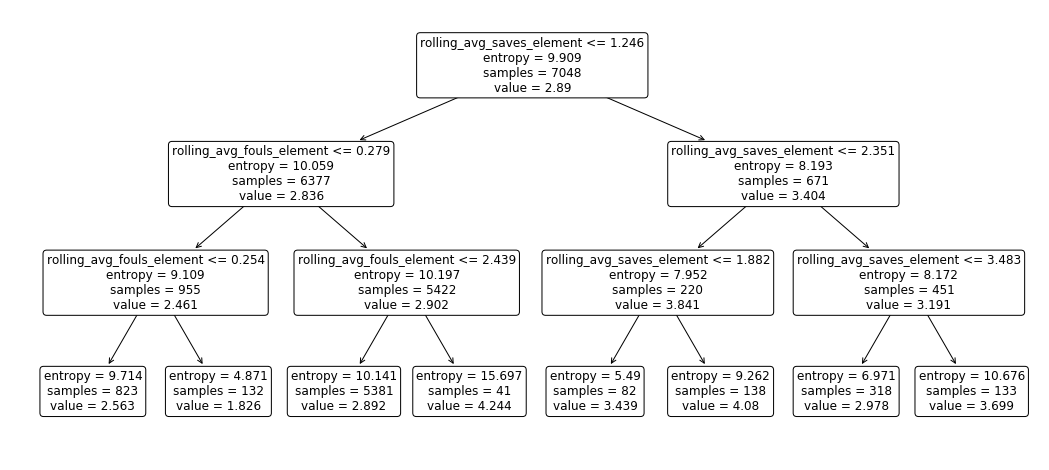

In [313]:
plt.figure(figsize=(18, 8))
plot_tree(
    model_example,
    impurity=True,
    fontsize=12,
    rounded=True,
    feature_names=example_cols
)
plt.show()

`value` corresponds to the prediction for that node, $ \hat c $ .  
`entropy` corresponds to the mean squared error for that node.

In [314]:
# for the first node
y.mean()

array(2.88989784)

In [315]:
# for the first node
((y - np.mean(y))**2).mean()

array(9.90898989)

Let's look at the decrease in loss achieved by the first split.

In [316]:
9.909 - ( 7.778 * 5608 + 16.101 * 1440)/7048

0.4305005675368925

## Trees are unstable

Decision trees have some drawbacks, in particular they are known to be unstable, with small variations in training data leading to different tree structures.  

Here's another decision tree, this time trained on a bootstrapped dataset. We see that the structure is quite different.

In [317]:
data_boot = random.choices(list(zip(X_example, y.ravel())), k=len(X_example)) 
X_boot = [i[0] for i in data_boot]
y_boot = [i[1] for i in data_boot]

In [318]:
model_boot = DecisionTreeRegressor(max_depth=3)

model_boot.fit(X_boot, y_boot)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

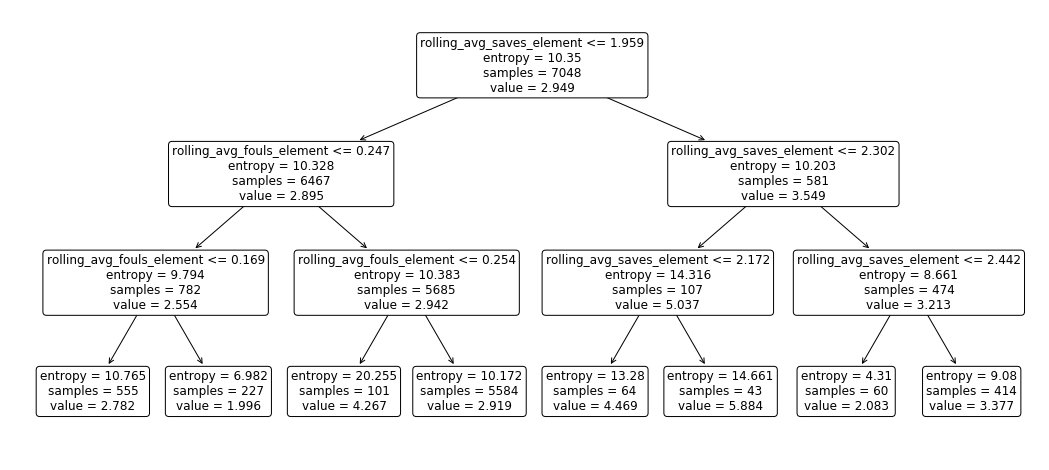

In [319]:
plt.figure(figsize=(18, 8))
plot_tree(
    model_boot,
    impurity=True,
    fontsize=12,
    rounded=True,
    feature_names=example_cols
)
plt.show()

## Tree size and overfitting

We prevent overfitting by limiting the tree size.  

There are several ways to control tree size, e.g. maximum tree depth, maximum number of leaves.

Let's look at how the minimum number of samples at each leaf affects the cross validation error.

In [321]:
?DecisionTreeRegressor

In [152]:
tree_parameters = {
    'min_samples_leaf': np.logspace(-2, -0.75, 50)
}

In [156]:
tree_model = GridSearchCV(
    DecisionTreeRegressor(),
    tree_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=5,
    error_score=100, n_jobs=1)
tree_model.fit(X, y.ravel())

tree_model_df = pd.DataFrame(tree_model.cv_results_)[[
    'param_min_samples_leaf',
    'split0_test_neg_mean_squared_error'
]]

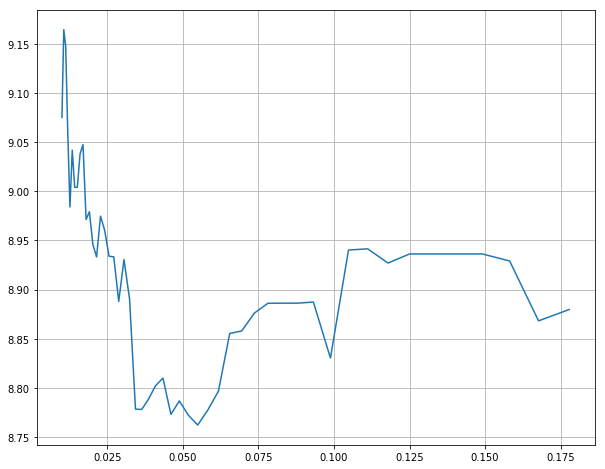

In [157]:
plt.figure(figsize=(10, 8))
plt.plot(tree_model_df['param_min_samples_leaf'], -tree_model_df['split0_test_neg_mean_squared_error'])
# plt.xlim(0, 20)
plt.grid()
plt.show()

If our tree is too deep we overfit and if our tree is too shallow we overfit

# Random forests

**What's going on?**

Random forests use bagging (bootstrap aggregation), a general technique that involves creating B bootstrap datasets and training a model on each. The aim of bagging is to reduce the variance of our model by aggregating over many weaker models.  

In random forests, we train a decision tree on each bootstrap dataset. Our random forest makes predictions by taking the mean of all the bootstrap tree predictions:

$$ f(x) = {1 \over B} \sum_{b=1}^B f_b(x) $$

**Correlation between trees**

The generalisability of a random forest depends on the predictive strength of the individual trees as well as the correlation between them, with highly correlated trees typically leading to worse generalisability.  

To reduce the correlation between individual trees, we usually only consider a random subset of features at each node when splitting. However, this can also reduce the strength of our individual trees. So we use cross validation to determine to optimal size of our random subset of features to consider at each node.

Random forests are non-deterministic models as a result of these two sources of randomness: bootstrapping and random feature sampling. This means that random forests with the same hyperparameters trained on the same data can produce different predictions. So it's worth repeating cross validation to account for this variation


**Hyperparameters**

So we have a few hyperparameters to worry about:
- The size of the individual trees
- The size of the random subset of features used at each node
- The number of trees

In [325]:
?RandomForestRegressor

## Tree size

Tree size affects the strength of the individual trees

In [179]:
forest_ts_parameters = {
    'min_samples_leaf': [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.075, 0.1]
}

In [180]:
forest_ts_model = GridSearchCV(
    RandomForestRegressor(n_estimators=20, max_features=1.0),
    forest_ts_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=5,
    error_score=100, n_jobs=1)
forest_ts_model.fit(X, y.ravel())

forest_ts_model_df = pd.DataFrame(forest_ts_model.cv_results_)[[
    'param_min_samples_leaf',
    'split0_test_neg_mean_squared_error'
]]

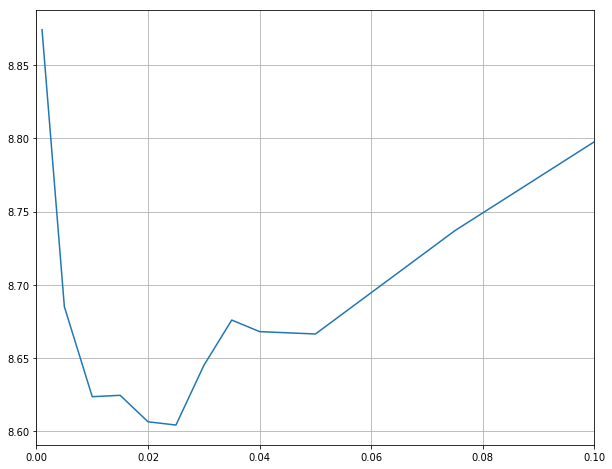

In [186]:
plt.figure(figsize=(10, 8))
plt.plot(forest_ts_model_df['param_min_samples_leaf'], -forest_ts_model_df['split0_test_neg_mean_squared_error'])
plt.xlim(0.0, 0.1)
plt.grid()
plt.show()

As before, deep trees overfit and shallow trees overfit

## Number of features

The number of features available to split on at each node affects the correlation between trees and the strenght of the trees

In [184]:
forest_nf_parameters = {
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

In [197]:
forest_nf_model_df_arr = []
for i in range(0, 20):
    forest_nf_model = GridSearchCV(
        RandomForestRegressor(n_estimators=20, min_samples_leaf=0.025),
        forest_nf_parameters,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=5,
        error_score=100, n_jobs=1)
    forest_nf_model.fit(X, y.ravel())

    forest_nf_model_df = pd.DataFrame(forest_nf_model.cv_results_)[[
        'param_max_features',
        'split0_test_neg_mean_squared_error'
    ]]
    
    forest_nf_model_df_arr.append(forest_nf_model_df)

In [201]:
forest_nf_model_df_all = pd.concat(forest_nf_model_df_arr)
forest_nf_model_df_all = \
forest_nf_model_df_all.groupby('param_max_features')[['split0_test_neg_mean_squared_error']].mean().reset_index()

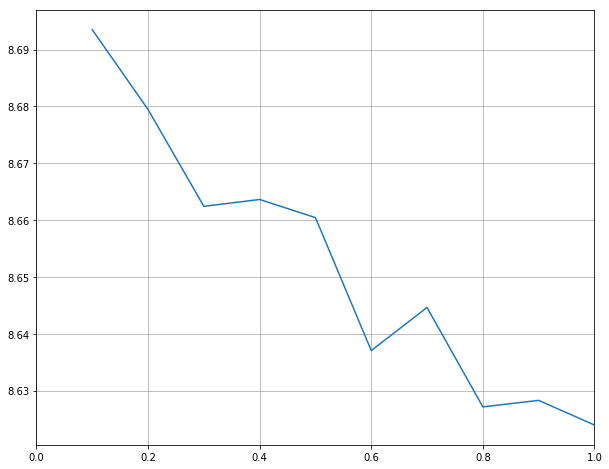

In [202]:
plt.figure(figsize=(10, 8))
plt.plot(forest_nf_model_df_all['param_max_features'], -forest_nf_model_df_all['split0_test_neg_mean_squared_error'])
plt.xlim(0, 1)
plt.grid()
plt.show()

In our case the reduction in tree strength seems to dominate the reduction in correlation

## Number of trees

More trees means a bigger sample to average over 

In [207]:
forest_nt_parameters = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64]
}

In [244]:
forest_nt_model_df_arr = []
for i in range(0, 100):
    forest_nt_model = GridSearchCV(
        RandomForestRegressor(min_samples_leaf=0.025, max_features=1.0),
        forest_nt_parameters,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=5,
        error_score=100, n_jobs=1)
    forest_nt_model.fit(X, y.ravel())

    forest_nt_model_df = pd.DataFrame(forest_nt_model.cv_results_)[[
        'param_n_estimators',
        'split0_test_neg_mean_squared_error'
    ]]
    
    forest_nt_model_df_arr.append(forest_nt_model_df)

In [245]:
forest_nt_model_df_all = pd.concat(forest_nt_model_df_arr)
forest_nt_model_df_all = \
forest_nt_model_df_all.groupby('param_n_estimators')[['split0_test_neg_mean_squared_error']].mean().reset_index()

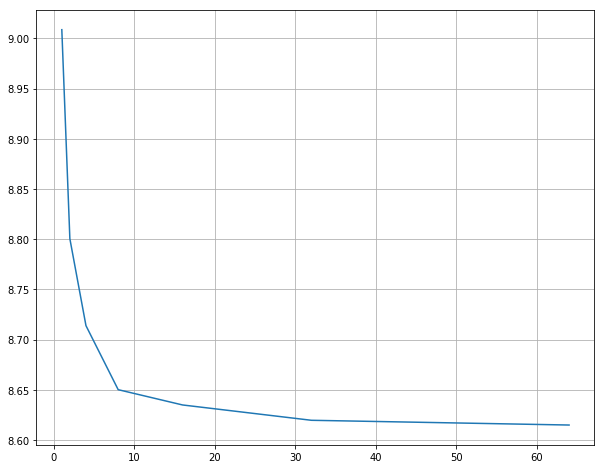

In [246]:
plt.figure(figsize=(10, 8))
plt.plot(forest_nt_model_df_all['param_n_estimators'], -forest_nt_model_df_all['split0_test_neg_mean_squared_error'])
# plt.xlim(0.0, 0.1)
plt.grid()
plt.show()

Adding more trees is only ever a good thing in terms of generalisability

# Gradient-boosted trees

## An aside on boosting

**What's going on here?**

Gradient boosting is another general technique where we build a model that is a linear combination of base learners
$$ f_M(x) = \sum_{m=1}^M \beta_m h(x; \theta_m) $$

Base learners are added to the overall sequence of models sequentially.

$$ f_m(x) = f_{m−1}(x) + \beta_m h(x; \theta_m)  $$

We minimise a chosen loss function for the overall sequence of models. We add the optimal base learner in a stagewise fashion whilst leaving existing models in the sequence unchanged:

$$ \theta_m, \beta_m =  \mathrm {arg} \min_{\theta, \beta} \sum_{i=1}^N L(y_i, f_{m−1}(x_i) + \beta h(x_i; \theta))  $$

**Inspiration from gradient descent**

In cases where this optimisation problem is not immediately tractable we take inspiration from numerical optimisation techniques. Specifically we look to steepest descent, an algorithm in which we seek to minimise some function, g(z), in terms of its argument, z, via a series of steps - or “boosts” - calculated using the gradient of g(z). The optimal value, z*, is found by taking M steps from some initial guess, $z_0$ .

$$ z^* = \sum_{m=0}^M z_m $$

$$ z_m = z_{m−1} − \rho_m \left[ {\partial g(z) \over \partial z} \right]_{z = z_{m−1}} $$

The optimal step length, $\rho_m$, is found using line search.


$$ \rho_m = \mathrm {arg} \min_{\rho} \;\;  g\left( z_{m−1} − \rho \left[ {\partial g(z) \over \partial z} \right]_{z = z_{m−1}}   \right) $$ 

**Boosting as gradient descent in function space**

In gradient boosting we find the best base learner to add to our sequence by fitting the new base learner to the direction of steepest descent of the chosen loss function. The new base learner is fit to this direction using squared-error loss.

$$ \theta_m = \mathrm {arg} \min_{\theta, \beta} \sum_{i=1}^N \left( −\left[ {\partial L(y_i, f(x_i)) \over \partial f(x_i)} \right]_{f(x_i) = f_{m−1}(x_i)} − \beta h(x_i; \theta)  \right)^2 $$

Our step length is again found using line search with respect to our chosen loss function.

$$ \rho_m = \mathrm {arg} \min_{\rho} \sum_{x_i}^N L(y_i, f_{m−1}(x_i) + \rho h(x_i; \theta_m) )$$
As such, we iteratively update our overall model with a series of “boosts” in terms of the base learners, each informed by the gradient of our chosen loss function, hence the name gradient boosting.

## Boosting with trees

In gradient-boosted trees, our base learners are individual decision trees. In case where we choose squared-error loss as our loss function, our model reduces to the following: 

$$ f_m(x) = f_{m−1}(x) +  \sum_{j=0}^{J_m} c_{jm} \, I(x \in R_{jm})$$

Each new tree in the sequence is grown to minimise the squared-error loss of the overall sequence, which is equivalent to growing each tree to predict the residuals from the existing overall sequence, yi - fm-1(xi ) .

$$ c_{jm} =  \mathrm {arg} \min_{c} \sum_{x_i \in R_{jm}} {1 \over 2}(y_i − f_{m−1}(x_i) − c)^2  $$

We can view gradient-boosted trees as a model that iteratively corrects itself to account for the errors in its predictions.


Now we've got a couple of hyperparameters to worry about (with more to come!):
- The size of the individual trees
- The number of boosting iterations

In [327]:
?GradientBoostingRegressor

## Tree size

In [213]:
boost_ts_parameters = {
    'min_samples_leaf': [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.075, 0.1]
}

In [215]:
boost_ts_model = GridSearchCV(
    GradientBoostingRegressor(
        criterion='mse',
        n_estimators=20,
        max_features=1.0,
        subsample=1.0,
        learning_rate=0.05
    ),
    boost_ts_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=5,
    error_score=100, n_jobs=1)
boost_ts_model.fit(X, y.ravel())

boost_ts_model_df = pd.DataFrame(boost_ts_model.cv_results_)[[
    'param_min_samples_leaf',
    'split0_test_neg_mean_squared_error'
]]

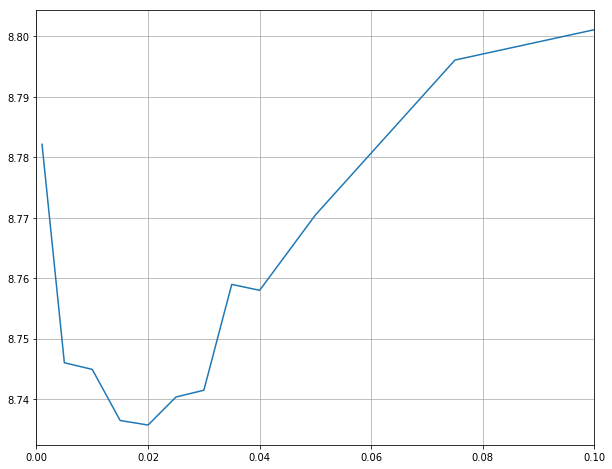

In [329]:
plt.figure(figsize=(10, 8))
plt.plot(boost_ts_model_df['param_min_samples_leaf'], -boost_ts_model_df['split0_test_neg_mean_squared_error'])
# plt.plot(forest_ts_model_df['param_min_samples_leaf'], -forest_ts_model_df['split0_test_neg_mean_squared_error'])
plt.xlim(0.0, 0.1)
plt.grid()
plt.show()

## Number of boosting iterations

In [226]:
boost_nt_parameters = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 256]
}

In [230]:
boost_nt_model_df_arr = []
for i in range(0, 1):
    boost_nt_model = GridSearchCV(
        GradientBoostingRegressor(
            criterion='mse',
            max_features=1.0,
            subsample=1.0,
            learning_rate=0.05,
            min_samples_leaf=0.02
        ),
            
        boost_nt_parameters,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=5,
        error_score=100, n_jobs=1)
    boost_nt_model.fit(X, y.ravel())

    boost_nt_model_df = pd.DataFrame(boost_nt_model.cv_results_)[[
        'param_n_estimators',
        'split0_test_neg_mean_squared_error'
    ]]
    
    boost_nt_model_df_arr.append(boost_nt_model_df)

In [231]:
boost_nt_model_df_all = pd.concat(boost_nt_model_df_arr)
boost_nt_model_df_all = \
boost_nt_model_df_all.groupby('param_n_estimators')[['split0_test_neg_mean_squared_error']].mean().reset_index()

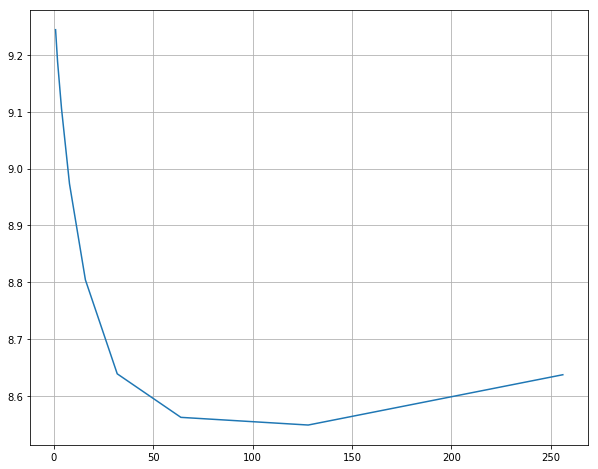

In [232]:
plt.figure(figsize=(10, 8))
plt.plot(boost_nt_model_df_all['param_n_estimators'], -boost_nt_model_df_all['split0_test_neg_mean_squared_error'])
# plt.xlim(0.0, 0.1)
plt.grid()
plt.show()

## Regularisation

We are also able to regularise our model by impeding the model updates via a shrinkage hyperparameter, 𝜈.

$$ f_m(x) = f_{m−1}(x) + \nu \sum_{j=0}^{J_m} c_{jm} \, I(x \in R_{jm})$$

Setting the shrinkage parameter to less than one slows the rate at which our sequence boosts towards the optimal model; in other words, it controls the learning rate of the model.


In [233]:
boost_lr_parameters = {
    'learning_rate': [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64]
}

In [234]:
boost_lr_model_df_arr = []
for i in range(0, 1):
    boost_lr_model = GridSearchCV(
        GradientBoostingRegressor(
            criterion='mse',
            n_estimators=20,
            max_features=1.0,
            subsample=1.0,
            min_samples_leaf=0.02
        ),
            
        boost_lr_parameters,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=5,
        error_score=100, n_jobs=1)
    boost_lr_model.fit(X, y.ravel())

    boost_lr_model_df = pd.DataFrame(boost_lr_model.cv_results_)[[
        'param_learning_rate',
        'split0_test_neg_mean_squared_error'
    ]]
    
    boost_lr_model_df_arr.append(boost_lr_model_df)

In [235]:
boost_lr_model_df_all = pd.concat(boost_lr_model_df_arr)
boost_lr_model_df_all = \
boost_lr_model_df_all.groupby('param_learning_rate')[['split0_test_neg_mean_squared_error']].mean().reset_index()

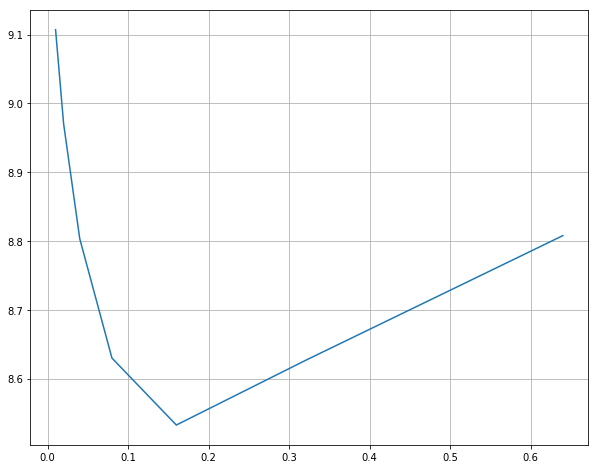

In [236]:
plt.figure(figsize=(10, 8))
plt.plot(boost_lr_model_df_all['param_learning_rate'], -boost_lr_model_df_all['split0_test_neg_mean_squared_error'])
# plt.xlim(0.0, 0.1)
plt.grid()
plt.show()

## Stochastic gradient-boosted trees

Inspired by the use of bagging in random forests, a modification was made to gradient boosting that has been found to improve its performance. At each iteration, we use a random subsample of training data to fit the base learner, rather than the entire training set. This procedure is known as subsampling and results in stochastic gradient boosting.  

Subsampling is similar to bagging, but with two key differences:
- in subsampling we sample from the training set without replacement, whereas in bagging we typically sample with replacement;
- accordingly, our subsample is smaller than the full training set, whereas in our implementation of random forests our bootstrapped dataset was the same size as the training dataset.

Subsampling has been found to generally improve the generalisability of gradient boosting models, though the reason for this is not clear. In Friedman’s original paper on the subject, he argues that the effect of subsampling is similar to bagging, where the reduction in correlation between our base learners  leads to a reduction in the variance of the overall model. In other words, introducing this randomness into the model helps prevent overfitting. 

In [237]:
boost_ss_parameters = {
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

In [241]:
boost_ss_model_df_arr = []
for i in range(0, 100):
    boost_ss_model = GridSearchCV(
        GradientBoostingRegressor(
            criterion='mse',
            n_estimators=20,
            max_features=1.0,
            learning_rate=0.05,
            min_samples_leaf=0.02
        ),
            
        boost_ss_parameters,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=5,
        error_score=100, n_jobs=1)
    boost_ss_model.fit(X, y.ravel())

    boost_ss_model_df = pd.DataFrame(boost_ss_model.cv_results_)[[
        'param_subsample',
        'split0_test_neg_mean_squared_error'
    ]]
    
    boost_ss_model_df_arr.append(boost_ss_model_df)

In [247]:
boost_ss_model_df_all = pd.concat(boost_ss_model_df_arr)
boost_ss_model_df_all = \
boost_ss_model_df_all.groupby('param_subsample')[['split0_test_neg_mean_squared_error']].mean().reset_index()

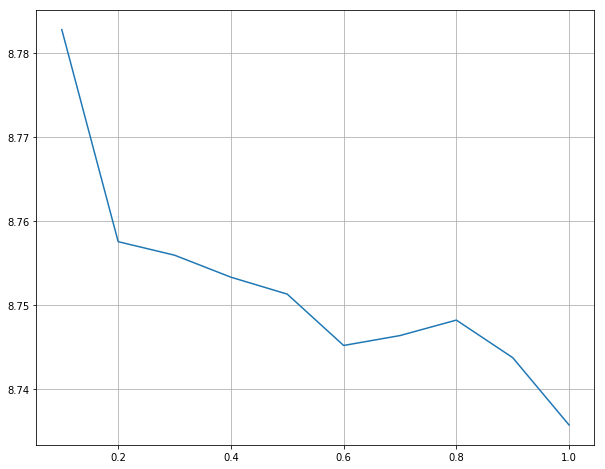

In [248]:
plt.figure(figsize=(10, 8))
plt.plot(boost_ss_model_df_all['param_subsample'], -boost_ss_model_df_all['split0_test_neg_mean_squared_error'])
# plt.xlim(0.0, 0.1)
plt.grid()
plt.show()